In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
from torch.optim.lr_scheduler import StepLR # Import your choice of scheduler here
import albumentations as A
from albumentations.pytorch import ToTensorV2

# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

use_cuda

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


True

In [3]:

#import model.py - contains model class which accepts type normalization method as input parameter
#instantiate Net class and check model summary
from model import MobileNetV1

model = MobileNetV1(ch_in=3, n_classes=10).to(device)

summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             864
       BatchNorm2d-2           [-1, 32, 16, 16]              64
              ReLU-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]             288
       BatchNorm2d-5           [-1, 32, 16, 16]              64
              ReLU-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]           2,048
       BatchNorm2d-8           [-1, 64, 16, 16]             128
              ReLU-9           [-1, 64, 16, 16]               0
           Conv2d-10             [-1, 64, 8, 8]             576
      BatchNorm2d-11             [-1, 64, 8, 8]             128
             ReLU-12             [-1, 64, 8, 8]               0
           Conv2d-13            [-1, 128, 8, 8]           8,192
      BatchNorm2d-14            [-1, 12

In [4]:
# import function to load CIFAR dataset
from loadcifar import load_CIFAR

#set batch size
batch_size = 64

#define tranformations for train and test datasets

train_transform = A.Compose([
    A.HorizontalFlip(), # Same with transforms.RandomHorizontalFlip()
    A.ShiftScaleRotate(shift_limit = 0.06, scale_limit = 0.1, rotate_limit = 45),
    A.CoarseDropout(min_holes = 1, max_holes=1, min_height=16, max_width=16, min_width=16, max_height=16, fill_value = [127,127,127], mask_fill_value = None),
    A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ToTensorV2()
])

#load training dataset
classes, train_loader = load_CIFAR(train_transform, batch_size=batch_size)
#load test dataset
_, test_loader = load_CIFAR(test_transform, batch_size)

100%|██████████| 170M/170M [00:03<00:00, 47.8MB/s]


Extracting /root/data/cifar10/cifar-10-python.tar.gz to /root/data/cifar10
Files already downloaded and verified


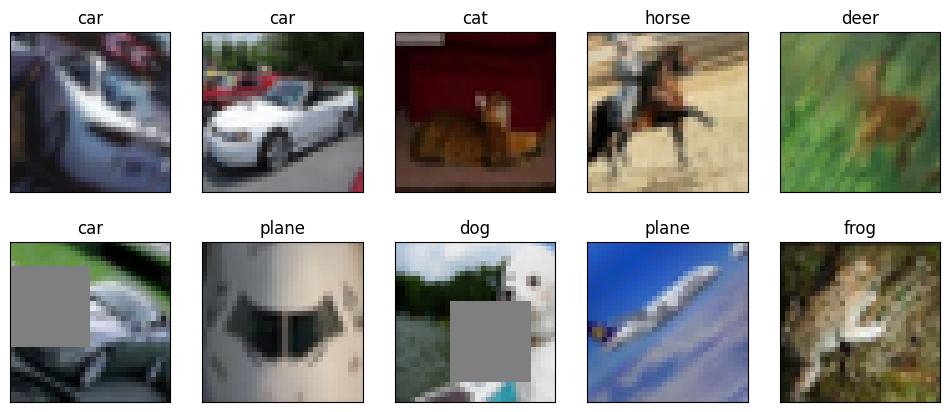

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
images, labels = next(iter(train_loader))

no_images = 10

figure = plt.figure(figsize=(12, 5))

for index in range(1, no_images + 1):
    plt.subplot(2, 5, index)
    imshow(images[index - 1])
    plt.tick_params(left=False, right=False, labelleft=False,
                    labelbottom=False, bottom=False)
    title = str(classes[labels[index - 1]])
    plt.title(title)


In [6]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR # Import your choice of scheduler here
#import test function
from testfns import test

def train(model, train_loader, test_loader, device, epochs = 2):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = StepLR(optimizer, step_size=40, gamma=0.1)

    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        correct = 0.0

        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            output = model(inputs)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()

        print("Epoch: ", epoch, "Learning Rate: ", optimizer.param_groups[0]["lr"])
        print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            loss, correct, len(train_loader.dataset),
            100. * correct / len(train_loader.dataset)))
        test(model, device, test_loader)

        #increment learning rate
        scheduler.step()

    print('Finished Training')

    return model

In [7]:
model = MobileNetV1(ch_in=3, n_classes=10).to(device)
train(model, train_loader, test_loader, device, epochs = 100)

Epoch:  0 Learning Rate:  0.001

Train set: Average loss: 1.8875, Accuracy: 18137.0/50000 (36.27%)


Test set: Average loss: 0.0120, Accuracy: 21555/50000 (43.11%)

Epoch:  1 Learning Rate:  0.001

Train set: Average loss: 1.6617, Accuracy: 21352.0/50000 (42.70%)


Test set: Average loss: 0.0114, Accuracy: 23822/50000 (47.64%)

Epoch:  2 Learning Rate:  0.001

Train set: Average loss: 1.9099, Accuracy: 23172.0/50000 (46.34%)


Test set: Average loss: 0.0105, Accuracy: 25250/50000 (50.50%)

Epoch:  3 Learning Rate:  0.001

Train set: Average loss: 1.8356, Accuracy: 24595.0/50000 (49.19%)


Test set: Average loss: 0.0105, Accuracy: 25796/50000 (51.59%)

Epoch:  4 Learning Rate:  0.001

Train set: Average loss: 1.2563, Accuracy: 25677.0/50000 (51.35%)


Test set: Average loss: 0.0099, Accuracy: 27074/50000 (54.15%)

Epoch:  5 Learning Rate:  0.001

Train set: Average loss: 1.2659, Accuracy: 26380.0/50000 (52.76%)


Test set: Average loss: 0.0092, Accuracy: 28909/50000 (57.82%)

Epoch:  6 

MobileNetV1(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 128, kernel_size=(1, 1